# optimization of parameters

In [108]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
from itertools import product
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Preprocess the data #['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Group data by 'usubjid' to maintain sequence structure
grouped_data = data_cleaned.groupby('usubjid')
shuffled_df = grouped_data.sample(frac=1, random_state=42).sort_values(['usubjid', 'ady_dna'])
grouped_data = shuffled_df.reset_index(drop=True).groupby('usubjid')

X_grouped = [group[features].values for name, group in grouped_data]
y_grouped = [group[target].values for name, group in grouped_data]

# Calculate the split index for 80%/20%
split_index = int(0.80 * len(X_grouped))

# Split the sequences into training and testing sets
X_train_grouped = X_grouped[:split_index]
X_test_grouped = X_grouped[split_index:]
y_train_grouped = y_grouped[:split_index]
y_test_grouped = y_grouped[split_index:]

# Concatenate the sequences to form the training and testing sets
X_train = np.concatenate(X_train_grouped)
X_test = np.concatenate(X_test_grouped)
y_train = np.concatenate(y_train_grouped)
y_test = np.concatenate(y_test_grouped)

# Define the grid of parameters
# This parameter represents the initial guess for the state vector's mean values at the beginning of the filtering process.
initial_state_means = [np.zeros(X_train.shape[1]), np.ones(X_train.shape[1])]
# The transition matrix describes how the state vector evolves from one time step to the next in the absence of noise 
transition_matrices = [np.eye(X_train.shape[1]), 0.95 * np.eye(X_train.shape[1])] 
#The observation matrix maps the true state space (which might not be directly observable) to the observed data
observation_matrices = [np.eye(X_train.shape[1]), 0.9 * np.eye(X_train.shape[1])]
# This parameter defines the covariance of the process noise, which accounts for the uncertainty in the evolution of the state vector.
process_noise_covariances = [0.01 * np.eye(X_train.shape[1]), 0.1 * np.eye(X_train.shape[1])]
# This parameter defines the covariance of the observation noise, which reflects the uncertainty in your measurements.
observation_noise_covariances = [0.1 * np.eye(X_train.shape[1]), 0.5 * np.eye(X_train.shape[1])]
# The initial covariance matrix represents the uncertainty in the initial state estimate
initial_covariances = [0.1 * np.eye(X_train.shape[1]), np.eye(X_train.shape[1])]

# Weights for the combined metric
alpha = 0.5  # Weight for residual standard deviation
beta = 0.5   # Weight for covariance matrix difference

# Grid search
best_combined_score = np.inf
best_params = None

# Lists to store all results
results = []
residual_means = []
residual_stds = []
covariance_diffs = []
combined_metrics = []

for param_combination in product(initial_state_means, transition_matrices, observation_matrices, process_noise_covariances, observation_noise_covariances, initial_covariances):
    initial_mean, A, C, Q, R, P_0 = param_combination
    
    # Initialize the Kalman Filter with current parameters
    kf = KalmanFilter(
        initial_state_mean=initial_mean,
        transition_matrices=A,
        observation_matrices=C,
        transition_covariance=Q,
        observation_covariance=R,
        initial_state_covariance=P_0,
        n_dim_obs=X_train.shape[1],
        n_dim_state=X_train.shape[1]
    )
    
    # Train the filter using EM
    kf = kf.em(X_train, n_iter=50)
    
    # Filter the test data
    state_means, state_covariances = kf.filter(X_test)
    
    # Metric 1: Residual Analysis
    residuals = X_test - state_means
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    residual_means.append(residual_mean)
    residual_stds.append(residual_std)
    
    # Metric 2: Covariance Matrix Stability
    if len(covariance_diffs) > 0:
        covariance_diff = np.linalg.norm(state_covariances - prev_covariance_matrix)
        covariance_diffs.append(covariance_diff)
    else:
        covariance_diffs.append(0)  # No comparison for the first iteration
    
    prev_covariance_matrix = state_covariances
    
    # Store the current configuration and results
    results.append({
        'initial_state_mean': initial_mean,
        'transition_matrix': A,
        'observation_matrix': C,
        'process_noise_covariance': Q,
        'observation_noise_covariance': R,
        'initial_covariance': P_0,
        'residual_mean': residual_mean,
        'residual_std': residual_std,
        'covariance_diff': covariance_diffs[-1],
    })

# Normalize after collecting all values
scaler = MinMaxScaler()
normalized_residual_stds = scaler.fit_transform(np.array(residual_stds).reshape(-1, 1)).flatten()
normalized_covariance_diffs = scaler.fit_transform(np.array(covariance_diffs).reshape(-1, 1)).flatten()

# Calculate combined metrics
for i in range(len(results)):
    combined_metric = alpha * normalized_residual_stds[i] + beta * normalized_covariance_diffs[i]
    combined_metrics.append(combined_metric)
    
    # Update the best parameters based on the combined metric
    if combined_metric < best_combined_score:
        best_combined_score = combined_metric
        best_params = results[i]

    print(f"Residual Mean = {results[i]['residual_mean']:.4f}, Residual Std Dev = {results[i]['residual_std']:.4f}, Covariance Diff = {results[i]['covariance_diff']:.4f}, Combined Metric = {combined_metric:.4f}")

# Store the best parameters
print("\nBest Parameters Found Based on Combined Metric:")
print(best_params)


Residual Mean = 0.3008, Residual Std Dev = 44.6452, Covariance Diff = 0.0000, Combined Metric = 0.0773
Residual Mean = 0.1514, Residual Std Dev = 45.3376, Covariance Diff = 151.2081, Combined Metric = 0.0817
Residual Mean = 0.9574, Residual Std Dev = 111.8541, Covariance Diff = 46529.7477, Combined Metric = 0.6391
Residual Mean = 0.8577, Residual Std Dev = 114.8234, Covariance Diff = 8927.6148, Combined Metric = 0.4947
Residual Mean = 0.1850, Residual Std Dev = 32.4538, Covariance Diff = 16732.4384, Combined Metric = 0.0828
Residual Mean = 0.1077, Residual Std Dev = 32.4779, Covariance Diff = 68.0992, Combined Metric = 0.0119
Residual Mean = 0.3441, Residual Std Dev = 37.7324, Covariance Diff = 21258.2356, Combined Metric = 0.1307
Residual Mean = 0.1643, Residual Std Dev = 38.4826, Covariance Diff = 259.6968, Combined Metric = 0.0451
Residual Mean = -13.7790, Residual Std Dev = 49.5425, Covariance Diff = 109080.5172, Combined Metric = 0.5691
Residual Mean = -13.9783, Residual Std Dev =

# Save and export results

In [109]:
import os
import json
# Create an output directory if it doesn't exist
output_dir = "../Outputs"
patient = "_No_"
full = "_partial_"
features = "_AS/AM_"
# Change accordingly
experiments_log = "80%train_50iter_commetrics_" + patient + full + features
path = os.path.join(output_dir, experiments_log)

Best parameters saved to ../Outputs/80%train_50iter_commetrics__No__partial__AS/AM_/best_parameters.json


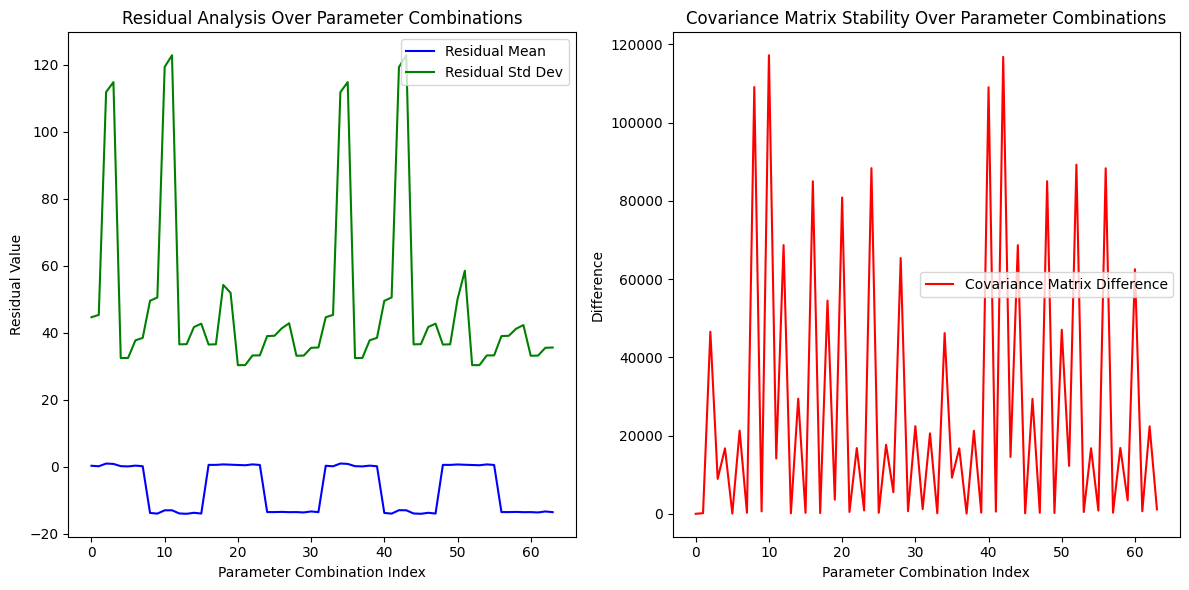

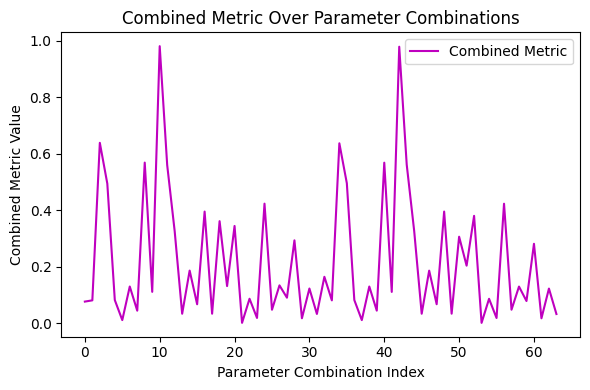

Best parameters saved to ../Outputs/80%train_50iter_commetrics__No__partial__AS/AM_/best_parameters.json
All results saved to ../Outputs/80%train_50iter_commetrics__No__partial__AS/AM_/all_results.csv
Plots saved to ../Outputs/80%train_50iter_commetrics__No__partial__AS/AM_/residual_covariance_plots.png and ../Outputs/80%train_50iter_commetrics__No__partial__AS/AM_/combined_metric_plot.png


In [110]:
# Ensure the directory exists
os.makedirs(path, exist_ok=True)

# Assuming `best_params`, `results`, `residual_means`, `residual_stds`, `covariance_diffs`, and `combined_metrics` are already calculated

# Define file paths
results_csv_file = os.path.join(path, "all_results.csv")
residual_plot_file = os.path.join(path, "residual_covariance_plots.png")
combined_metric_plot_file = os.path.join(path, "combined_metric_plot.png")

# # Save best parameters to a CSV file
# best_params_file = os.path.join(path, "best_parameters.csv")
# best_params_df = pd.DataFrame([best_params])
# best_params_df.to_csv(best_params_file, index=False)

# Convert numpy arrays to lists
best_params_serializable = {k: v.tolist() for k, v in best_params.items()}
best_params_file = os.path.join(path, "best_parameters.json")

# Save the best parameters to a JSON file
with open(best_params_file, 'w') as json_file:
    json.dump(best_params_serializable, json_file, indent=4)

print(f"Best parameters saved to {best_params_file}")


# Save all results to a CSV file
results_df = pd.DataFrame(results)
results_df.to_csv(results_csv_file, index=False)

# Visualize and save the metrics

# Plot Residual Metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(residual_means, 'b-', label='Residual Mean')
plt.plot(residual_stds, 'g-', label='Residual Std Dev')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Residual Value')
plt.title('Residual Analysis Over Parameter Combinations')
plt.legend()

# Plot Covariance Matrix Differences
plt.subplot(1, 2, 2)
plt.plot(covariance_diffs, 'r-', label='Covariance Matrix Difference')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Difference')
plt.title('Covariance Matrix Stability Over Parameter Combinations')
plt.legend()

# Save the residual and covariance plots
plt.tight_layout()
plt.savefig(residual_plot_file)

plt.show()

# Plot Combined Metric
plt.figure(figsize=(6, 4))
plt.plot(combined_metrics, 'm-', label='Combined Metric')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Combined Metric Value')
plt.title('Combined Metric Over Parameter Combinations')
plt.legend()

# Save the combined metric plot
plt.tight_layout()
plt.savefig(combined_metric_plot_file)

plt.show()

print(f"Best parameters saved to {best_params_file}")
print(f"All results saved to {results_csv_file}")
print(f"Plots saved to {residual_plot_file} and {combined_metric_plot_file}")


# Retraining and optimize the iteration steps

### add path to bins

In [111]:
import os
import sys
# Get the path to the current directory of the script
bins_path = "/Users/jzeng63/Desktop/CDNA/ML/HMM/TS/Bins"
sys.path.append(bins_path)

In [112]:
import numpy as np
import json
import pandas as pd
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [113]:
output_dir = "../Outputs"
patient = "_No_"
full = "_partial_"
features = "_AS/AM_"
# Change accordingly
experiments_log = "80%train_50iter_commetrics_" + patient + full + features
path = os.path.join(output_dir, experiments_log)

In [114]:
best_params_file = os.path.join(path, "best_parameters.json")
# Function to read JSON file
def read_json_file(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"Error: The file at {file_path} was not found.")
    except json.JSONDecodeError:
        print("Error: The file could not be decoded. Ensure it's a valid JSON file.")

best_params = read_json_file(best_params_file)

In [115]:
initial_mean = np.array(best_params["initial_state_mean"])
A = np.array(best_params["transition_matrix"])
C = np.array(best_params["observation_matrix"])
Q = np.array(best_params["process_noise_covariance"])
R = np.array(best_params["observation_noise_covariance"])
P_0 = np.array(best_params["initial_covariance"])

In [116]:
# _prepare_training(data_path = '../../../Data_processing/Outputs/train.csv', features = ['aval_AlloMap',          'aval_AlloSure', 'ady_dna'], exclusion = True, split = 0.8, patient_level = True)

In [117]:

# Load the cleaned dataset
data_cleaned = pd.read_csv('../../../Data_processing/Outputs/train.csv')

# Exclusion or inclusion only rejection samples
# data_cleaned = data_cleaned.loc[data_cleaned['usubjid'].isin(data_cleaned[data_cleaned['label'] == 1]["usubjid"].unique())]
data_cleaned.dropna(inplace=True)

# Preprocess the data #['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
features = ['aval_AlloMap', 'aval_AlloSure', 'ady_dna']
target = 'label'

# Group data by 'usubjid' to maintain sequence structure
grouped_data = data_cleaned.groupby('usubjid')
shuffled_df = grouped_data.sample(frac=1, random_state=42).sort_values(['usubjid', 'ady_dna'])
grouped_data = shuffled_df.reset_index(drop=True).groupby('usubjid')

X_grouped = [group[features].values for name, group in grouped_data]
y_grouped = [group[target].values for name, group in grouped_data]

# Calculate the split index for 80%/20%
split_index = int(0.80 * len(X_grouped))

# Split the sequences into training and testing sets
X_train_grouped = X_grouped[:split_index]
X_test_grouped = X_grouped[split_index:]
y_train_grouped = y_grouped[:split_index]
y_test_grouped = y_grouped[split_index:]

# Concatenate the sequences to form the training and testing sets
X_train = np.concatenate(X_train_grouped)
X_test = np.concatenate(X_test_grouped)
y_train = np.concatenate(y_train_grouped)
y_test = np.concatenate(y_test_grouped)

In [118]:
kf = KalmanFilter(
    initial_state_mean=initial_mean,
    transition_matrices=A,
    observation_matrices=C,
    transition_covariance=Q,
    observation_covariance=R,
    initial_state_covariance=P_0,
    n_dim_obs=X_train.shape[1],
    n_dim_state=X_train.shape[1]
)

Iteration 1: Residual Mean = 2.9558, Residual Std Dev = 45.9939
Iteration 2: Residual Mean = 2.7178, Residual Std Dev = 47.8884
Iteration 2: Covariance Matrix Difference = 154993.9984
Iteration 3: Residual Mean = 2.4996, Residual Std Dev = 48.7336
Iteration 3: Covariance Matrix Difference = 76098.3984
Iteration 4: Residual Mean = 2.3227, Residual Std Dev = 49.0458
Iteration 4: Covariance Matrix Difference = 36174.6549
Iteration 5: Residual Mean = 2.1820, Residual Std Dev = 49.1091
Iteration 5: Covariance Matrix Difference = 16763.8290
Iteration 6: Residual Mean = 2.0690, Residual Std Dev = 49.0633
Iteration 6: Covariance Matrix Difference = 7520.7869
Iteration 7: Residual Mean = 1.9766, Residual Std Dev = 48.9739
Iteration 7: Covariance Matrix Difference = 3171.7081
Iteration 8: Residual Mean = 1.8995, Residual Std Dev = 48.8707
Iteration 8: Covariance Matrix Difference = 1146.4666
Iteration 9: Residual Mean = 1.8344, Residual Std Dev = 48.7667
Iteration 9: Covariance Matrix Difference

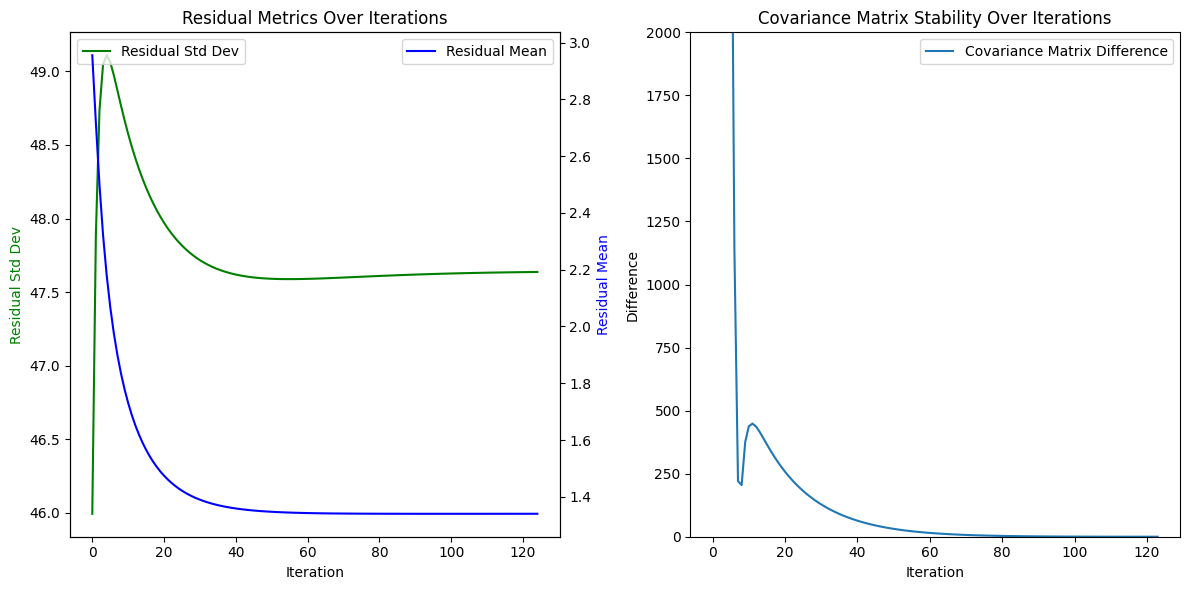

In [119]:
# Estimate the Kalman Filter parameters using EM algorithm and track convergence metrics
residual_means = []
residual_stds = []
covariance_diffs = []
prev_covariance_matrix = None
for i in range(125):
    kf = kf.em(X_train, n_iter=1)
    
    # Use the filter to estimate the hidden states
    state_means, state_covariances = kf.filter(X_test)
    
    # Calculate residuals
    residuals = X_test - state_means
    
    # Metric 1: Residual Analysis
    residual_mean = np.mean(residuals)
    residual_std = np.std(residuals)
    
    residual_means.append(residual_mean)
    residual_stds.append(residual_std)
    
    print(f"Iteration {i+1}: Residual Mean = {residual_mean:.4f}, Residual Std Dev = {residual_std:.4f}")
    
    # Metric 2: Covariance Matrix Stability
    if prev_covariance_matrix is not None:
        covariance_diff = np.linalg.norm(state_covariances - prev_covariance_matrix)
        covariance_diffs.append(covariance_diff)
        print(f"Iteration {i+1}: Covariance Matrix Difference = {covariance_diff:.4f}")
    prev_covariance_matrix = state_covariances

# Final Filter Application
state_means, state_covariances = kf.filter(X_test)

# Plot the metrics
plt.figure(figsize=(12, 6))

# Plot Residual Std Dev with Residual Mean on a secondary Y-axis
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(residual_stds, 'g-', label='Residual Std Dev')
ax2.plot(residual_means, 'b-', label='Residual Mean')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Residual Std Dev', color='g')
ax2.set_ylabel('Residual Mean', color='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Residual Metrics Over Iterations')

# Plot Covariance Matrix Differences
plt.subplot(1, 2, 2)
plt.plot(covariance_diffs, label='Covariance Matrix Difference')
plt.ylim(0, 2000)
plt.title('Covariance Matrix Stability Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Difference')
plt.legend()

plt.tight_layout()
plt.show()

# Test the inference using retrained model

In [128]:
# Use the state means for predictions
predicted_allosure = state_means[:, 1]
# predicted_allomap = state_means[:, 0]

# Calculate predicted labels based on a threshold (e.g., 0.5)
predicted_labels = (predicted_allosure > 0.5).astype(int)

# predicted_labels = (predicted_allomap > 30).astype(int)

# Calculate predicted labels based on the given thresholds
# The label will be 1 (positive) if both conditions are satisfied
# predicted_labels = np.where((predicted_allosure > 0.5) & (predicted_allomap > 30), 1, 0)


# Evaluate the performance
print("Classification Report:")
print(classification_report(y_test, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predicted_labels))

# Calculate AUC
auc = roc_auc_score(y_test, predicted_allosure)
print(f"AUC: {auc}")

# Calculate AUC of baseline
auc = roc_auc_score(y_test, X_test[:, 0])
print(f"Baseline_AUC: {auc}")

accuracy = accuracy_score(y_test, predicted_labels)
print(f"Accuracy: {accuracy}")

# Calculate baseline of accuracy
predicted_labels = (X_test[:, 0] > 30).astype(int)
accuracy = accuracy_score(y_test, predicted_labels)
print(f"Baseline_Accuracy: {accuracy}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      2114
         1.0       0.37      0.41      0.39       186

    accuracy                           0.90      2300
   macro avg       0.66      0.68      0.67      2300
weighted avg       0.90      0.90      0.90      2300

Confusion Matrix:
[[1985  129]
 [ 109   77]]
AUC: 0.7359436831771803
Baseline_AUC: 0.5728909166742963
Accuracy: 0.8965217391304348
Baseline_Accuracy: 0.4926086956521739


# export the model

### model name

In [125]:
iteration = str(125)
model_name = path.split("/")[-1] + iteration + ".pkl"

In [127]:
print (path)

../Outputs/80%train_50iter_commetrics__No__partial__AS/AM_


In [123]:
import joblib

model_directory = "../models"
model_path = os.path.join(model_directory, model_name)
# Save the model to a file
joblib.dump(kf, model_path)

['../models/AM_125.pkl']